# Simulating Cyclic Voltammograms

In this notebook, Cyclic Voltammograms are simulated by varying voltage while keeping track of adsorbates

In [1]:
#### Import packages
import warnings
warnings.filterwarnings('ignore')

import sys
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy

#### Import functions from PUK.py
sys.path.append('../scripts')
from PUK import on_top_site_vector, hollow_site_vector, pandas_to_DMatrix, pandas_to_DMatrix, surface_to_energies, energies_to_charge_isoterm, charge_isoterm_to_CV, rolling_average_smoothing, surface_to_CV, surface_composition, super_surface_plot, create_surface, plot_voltammograms, create_empty_adsorbates, surface_to_energies_matrices, argmin2d, find_smallest_energy, count_adsorbates, count_adsorbates_full, make_voltage_range, steric_hindrance


In [2]:
#### Load models
hollow_site_model = xgb.Booster({'nthread': 4})
hollow_site_model.load_model("../models/"+"Hollow_site.model")

on_top_site_model = xgb.Booster({'nthread': 4})
on_top_site_model.load_model("../models/"+"on_top_site.model")

## Simulate surface

In [3]:
#### Simulate surface (and matrices for keeping track of the adsorbates (both hollow and on-top))
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
dim_x, dim_y = 100, 100
surface = create_surface(metals, dim_x, dim_y, "Even")
adsorbates_hollow, adsorbates_on_top = create_empty_adsorbates(dim_x, dim_y)

print(count_adsorbates_full(adsorbates_hollow, adsorbates_on_top))

{'H': 0, 'OH': 0, 'O': 0, 'empty': 20000}


## Simulate surface, adsorbates, varying the voltage

In [9]:
adsorbates_log = []
sum_delta_G_log = []

hysteresis_threshold = 0
steric_bonus_energy = 0.05
voltage_range = make_voltage_range(0.25, 2, -1, 1, 1000) #V_start, V_max, V_min, num_rounds, points_per_round
#voltage_range = [1.8]
for potential in tqdm(voltage_range):
    ### Print the voltage ###
    #print(f"Potential: {potential:.2f} V")
    
    ### Calculate all energies on the surface for all adsorbates ###
    H_matrix, OH_matrix, O_matrix = surface_to_energies_matrices(surface, potential, on_top_site_model, hollow_site_model)
    Energies_matrix = {"H": H_matrix, "OH": OH_matrix, "O": O_matrix}
    Energies_matrix_count = copy.deepcopy(Energies_matrix)
    ### REMOVE ADSORBATES WITH POSITIVE ENERGY ###
    # Look through all adsorbate sites (hollow and on-top)
    # If occupied, remove at positive energy (or above hysteresis barrier)
    for idx_x in range(dim_x):
        for idx_y in range(dim_y):
            
            ### REMOVE HOLLOW SITE ADSORBATES ###
            hollow_adsorbate = adsorbates_hollow[idx_x, idx_y] # Find the adsorbate
            if hollow_adsorbate != "empty": # If the spot is not empty
                hollow_adsorbate_energy = Energies_matrix[hollow_adsorbate][idx_x, idx_y] #Check the energy at that spot with that adsorbate
                
                # Korriger for nabo-interaktioner? Ja. Læg noget til energien baseret på antallet af naboer
                hollow_adsorbate_energy += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, "H", adsorbates_hollow, adsorbates_on_top)
                
                if hollow_adsorbate_energy > hysteresis_threshold: # Hysteresis could be inserted here
                    #print(f"Removing adsorbate {hollow_adsorbate} because the energy is {hollow_adsorbate_energy}")
                    adsorbates_hollow[idx_x, idx_y] = "empty" # The adsorbate is removed
                    #print(f"The hollow_adsorbate at this place is now {adsorbates_hollow[idx_x, idx_y]}")
            
            ### REMOVE ON-TOP SITE ADSORBATES ###
            on_top_adsorbate = adsorbates_on_top[idx_x, idx_y] # Find the adsorbate
            if on_top_adsorbate != "empty": # If the spot is not empty
                on_top_adsorbate_energy = Energies_matrix[on_top_adsorbate][idx_x, idx_y] #Check the energy at that spot with that adsorbate
                
                # Korriger for nabo-interaktioner?
                on_top_adsorbate_energy += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, "OH", adsorbates_hollow, adsorbates_on_top)
                
                if on_top_adsorbate_energy > hysteresis_threshold: # Hysteresis could be inserted here
                    adsorbates_on_top[idx_x, idx_y] = "empty" # The adsorbate is removed
    
    
    # Kig igennem energierne ved de frie sites, læg nabo-interaktion-energier til, hvis energien stadig er 
    # negativ, så sæt den på. Ellers, så erstat energien med et "no", så man ikke finder samme energi igen
    
    # Find smallest energy in all three matrices
    smallest_energy = -1 #Just initially to get the while loop going
    # The absolute maximum number of smallest energies is dim_x * dim_y * 3. One energy is checked, if under 0 AND the spot is free -> attach the adsorbate, then set the energy to 100. If the smallest energy is not under 0 -> Exit the loop  
    #for iteration in range(dim_x*dim_y*3): #Maksimalt antal energier der skal tjekkes hvis alle er negative. Hvis man overskrider den her er der noget galt
    counter = 0
    while smallest_energy < 0:
        counter += 1
        if counter > dim_x*dim_y*3:
            raise ValueError("Exceeded the maxmimum amount of negative energies. Some energies keep getting found again and again. Make sure all checked energies are set to 100.")
        idx_x, idx_y, smallest_energy, adsorbate = find_smallest_energy(Energies_matrix)
        
        #Check if the position is occupied:
        if ((adsorbate == "H" or adsorbate == "O") and adsorbates_hollow[idx_x, idx_y] != "empty") or (adsorbate == "OH" and adsorbates_on_top[idx_x, idx_y] != "empty"):
            # The position was occupied. Remove the energies at this position
            if adsorbate == "H" or adsorbate == "O":
                Energies_matrix["H"][idx_x, idx_y] = 100
                Energies_matrix["O"][idx_x, idx_y] = 100
            
            if adsorbate == "OH":
                Energies_matrix["OH"][idx_x, idx_y] = 100
            continue # Ahh, hvis pladsen der hører til den laveste energi er optaget, så sæt energien på denne plads FOR SAMME ADSORBAT til 100. Så skal man ikke tjekke senere. Ellers kunne man også bare tjekke om pladsen er ledig for hver energi. Det burde være simplere
        
        # Add neighbor-interaction
        smallest_energy += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, adsorbate, adsorbates_hollow, adsorbates_on_top)
        
        # Remove that energy and put "checked" instead no matter what happened before
        if smallest_energy < 0: # ADSORPTION
            if adsorbate == "H" or adsorbate == "O":
                # Put the adsorbate on the adsorbates matrix
                adsorbates_hollow[idx_x, idx_y] = adsorbate
                
                # Remove the energies at this position
                Energies_matrix["H"][idx_x, idx_y] = 100
                Energies_matrix["O"][idx_x, idx_y] = 100
            
            if adsorbate == "OH":
                adsorbates_on_top[idx_x, idx_y] = adsorbate
                # Remove the energies at this position
                Energies_matrix["OH"][idx_x, idx_y] = 100
    
    
    ### SUM ADSORBATE ENERGIES ### 
    
    # Loop through all sites, add the energy of the adsorbate if one is found
    sum_delta_G = 0
    for idx_x in range(dim_x): #Perhaps I should add the 
        for idx_y in range(dim_y):
            # HOLLOW SITES
            if adsorbates_hollow[idx_x, idx_y] == "H":
                sum_delta_G += Energies_matrix_count["H"][idx_x, idx_y]
                sum_delta_G += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, "H", adsorbates_hollow, adsorbates_on_top)
                
            if adsorbates_hollow[idx_x, idx_y] == "O":
                sum_delta_G += Energies_matrix_count["O"][idx_x, idx_y]
                sum_delta_G += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, "O", adsorbates_hollow, adsorbates_on_top)
                
            if adsorbates_on_top[idx_x, idx_y] == "OH":
                sum_delta_G += Energies_matrix_count["OH"][idx_x, idx_y]
                sum_delta_G += steric_hindrance(steric_bonus_energy, idx_x, idx_y, dim_x, dim_y, "OH", adsorbates_hollow, adsorbates_on_top)
                
    sum_delta_G_log.append(sum_delta_G / (dim_x*dim_y))
    
    adsorbates_log.append(count_adsorbates_full(adsorbates_hollow, adsorbates_on_top))


  0%|          | 0/999 [00:00<?, ?it/s]

## Plot the cyclic voltammogram / results

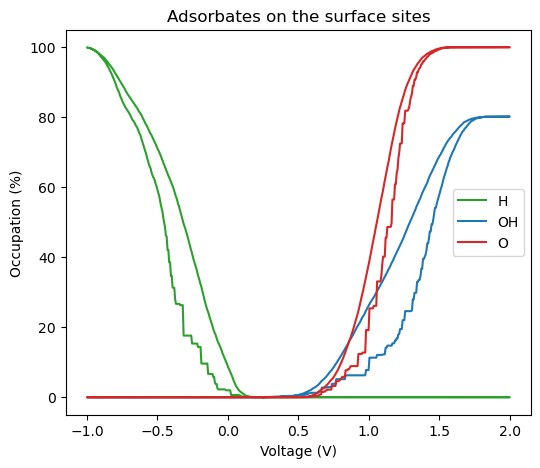

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
adsorbate_colours = {"H": "tab:green", "OH": "tab:blue", "O": "tab:red", "empty": "Grey"}
for adsorbate in ["H", "OH", "O"]:
    ax.plot(voltage_range, [adsorbates_log[n][adsorbate]/100 for n in range(len(adsorbates_log))], c = adsorbate_colours[adsorbate], label = adsorbate)

ax.set_title("Adsorbates on the surface sites")
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Occupation (%)")


ax.legend()
fig.show()

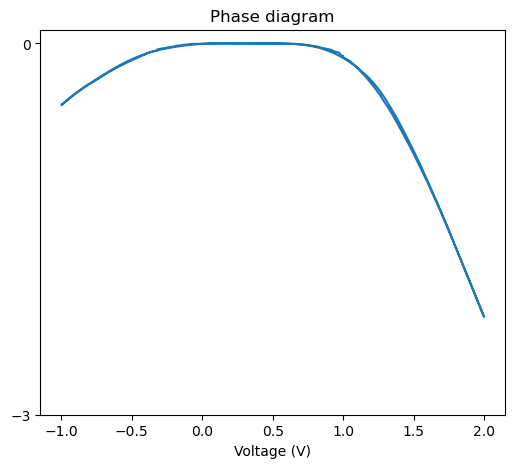

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, sum_delta_G_log)

ax.set_title("Phase diagram")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([0, -3])
fig.show()

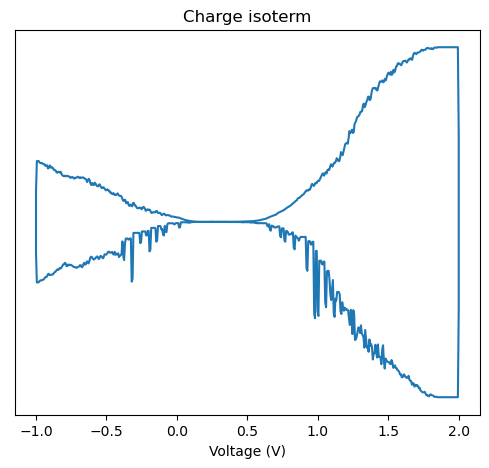

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, np.gradient(sum_delta_G_log))

ax.set_title("Charge isoterm")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([])
fig.show()

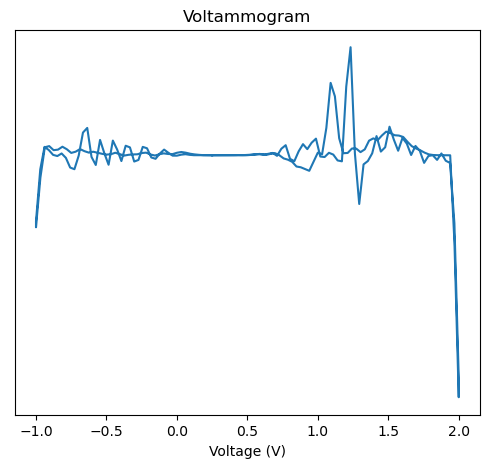

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(voltage_range, -np.gradient(np.gradient(sum_delta_G_log)))

ax.set_title("Voltammogram")
ax.set_xlabel("Voltage (V)")
ax.set_yticks([])
fig.show()

In [13]:
## For testing the steric hindrance function

bonus_energy = 0.1
idx_x, idx_y = 50, 50
adsorbate = "H"
steric_hindrance(bonus_energy, idx_x, idx_y, adsorbate, adsorbates_hollow, adsorbates_on_top)

0.8